In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Seed for reproducibility
np.random.seed(42)

# Introduction to Monte Carlo and Importance Sampling (IS)

In this notebook, we will explore **Importance Sampling (IS)** as a technique to estimate expectations over a probability density function $p(x)$ by sampling from a different, more convenient proposal distribution $ q(x) $.


## Goal

Our goal is to estimate the expectation of a function $ f(X) $ under $ p(x) $, specifically:
$$
\mu = \mathbb{E}_{p(x)}[f(X)] = \int f(x) p(x) \, dx,
$$
where:
- $ x \in D \subseteq \mathbb{R}^d$ is a **random variable** that has a probability density function $p(x)$.
- $ p(x) $ is the **target distribution**: the probability distribution we are interested in.
- $ f(x)$ is the **function of interest**. 






## Simple or crude Monte Carlo

When $p(x)$ is complex or high-dimensional, the previous integral cannot be computed in closed-form. Then we need to approximate its value.

The simplest solution is to use **Monte Carlo**:
$$
\widehat{\mu}_{MC} = \frac{1}{N} \sum_{i=1}^N f(X^i)
$$
where $X^i \sim p(x)$ are independent and identically distributed (i.i.d.) samples


### Challenges

Disadvantages of MC:
- **Computational cost**: Requires a **large number of samples** for accurate results.
- **Sampling issues**: Inefficient or problematic when sampling from $p(x)$ is either  
    - impossible: $p(x)$ is **too complex or unknown** (e.g., complex high-dimensional distributions)
    - or just inefficient: **rare event estimation** or distributions with high variance can lead to very few relevant samples, slowing convergence.


## Importance Sampling
Since it may be inefficient to sample directly from $ p(x) $, we use **Importance Sampling** by introducing a proposal distribution $ q(x) $, from which it is easier to sample.

Using Importance Sampling, the expectation can be rewritten as:
$$
\mathbb{E}_{p(x)}[f(X)] = \int f(x) \frac{p(x)}{q(x)} q(x) \, dx = \mathbb{E}_{q(x)} \left[ f(X) \frac{p(X)}{q(X)} \right]
$$

This leads to the **IS estimator**:
$$
\widehat{\mu}_{IS} = \frac{1}{N} \sum_{i=1}^N f(X_i) \frac{p(X_i)}{q(X_i)}
$$
where $ X_i \sim q(x) $ are i.i.d. samples from the proposal distribution.


Importance Sampling is particularly useful when:
1. **Direct sampling from** $ p(x)$ **is difficult**.
2. **Events of interest** under $ p(x)$ are rare, making direct Monte Carlo inefficient.


## Example: Rare Event
For $p(x) = \mathcal{N}(0,1)$, we want to compute $\mathbb{P}[X > 3]$. 

Thus, we define the function $ f(x) $ to be an indicator function for the event $X > 3$:
$$
f(x) = \mathbb{I}(X > 3),
$$
and we aim at computing
$$
\mathbb{P}[X > 3]= \mathbb{E}_{p(x)}[\mathbb{I}(X > 3)] = \int {\mathbb{I}(X > 3)} p(x) dx.
$$

- Note that this example has a closed-form solution. So we will compute the analytical solution, the Monte Carlo estimator and the importance sampling estimator.


In [2]:
# Define target distribution p(x) = N(0, 1)
mu_p = 0
sigma_p = 1

# Define the function we want to compute the expectation of (e.g., indicator function)
def f(x):
    return (x > 3).astype(float)  # Indicator function for a "rare event" where X > 3

### Closed-Form Solution

To verify the accuracy of our estimations, let's compute the **closed-form solution** for the expectation:

$$
\mathbb{E}_{p(x)}[\mathbb{I}(X > 3)] = \mathbb{P}(X > 3) = \int_{3}^{\infty} p(x) \, dx
$$

Since our target distribution $ p(x) $ is $ \mathcal{N}(0, 1) $, we can compute this probability directly using the cumulative distribution function (CDF) of the normal distribution.


In [3]:
# Closed-form probability of X > 3 under p(x) = N(0, 1)
closed_form_solution = 1 - norm.cdf(3, loc=mu_p, scale=sigma_p)
print(f"Closed-Form Solution for P(X > 3): {closed_form_solution}")


Closed-Form Solution for P(X > 3): 0.0013498980316301035


### Monte Carlo (MC) Estimation

Using direct Monte Carlo (MC), we can approximate the expectation by sampling directly from $ p(x) = \mathcal{N}(0, 1) $:

$$
\widehat{\mu}_{MC} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(X_i > 3)
$$

where $ X_i \sim p(x) $. This estimate converges to the true expectation as $ N $ increases.


In [4]:
# Number of samples
N = 20000

# Draw samples from the target distribution p(x) = N(0, 1)
samples_p = np.random.normal(mu_p, sigma_p, N)

# Monte Carlo estimate for E[f(X)] with f(X) = I(X > 3)
mc_estimate = np.mean(f(samples_p))
print(f"Monte Carlo Estimate of P(X > 3): {mc_estimate}")


Monte Carlo Estimate of P(X > 3): 0.0014


### Importance Sampling (IS) Estimation

To improve sampling efficiency, we use **Importance Sampling (IS)** with a proposal distribution $ q(x) = \mathcal{N}(3, 1) $. The IS estimator is given by:

$$
\widehat{\mu}_{IS} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(X_i > 3) \frac{p(X_i)}{q(X_i)}
$$

where $ X_i \sim q(x) $ are samples from the proposal distribution, and $ w(X_i) = \frac{p(X_i)}{q(X_i)} $ are the corresponding **importance weights**.


In [5]:
# Proposal distribution q(x) = N(3, 1)
mu_q = 3
sigma_q = 1

# Draw samples from the proposal distribution q(x) = N(3, 1)
samples_q = np.random.normal(mu_q, sigma_q, N)

# Evaluate target and proposal densities at the sample points
p_x = norm.pdf(samples_q, mu_p, sigma_p)  # Target density p(x) at samples
q_x = norm.pdf(samples_q, mu_q, sigma_q)  # Proposal density q(x) at samples

# Calculate IS weights
weights = p_x / q_x

# Importance Sampling estimate for E[f(X)] with f(X) = I(X > 3)
is_estimate = np.sum(weights * f(samples_q)) / np.sum(weights)
print(f"Importance Sampling Estimate of P(X > 3): {is_estimate}")


Importance Sampling Estimate of P(X > 3): 0.0011560883123428233


## Using the Log-Space Trick for Numerical Stability

When computing weights in importance sampling (IS), the weights are often derived from ratios of densities:
$$
w(X^i) = \frac{p(x^i)}{q(x^i)}
$$
or equivalently, in log-space:
$$
\log w(X^i) = \log p(x^i) - \log q(x^i).
$$

In practice, these weights can involve exponential terms that are either extremely large or small, leading to **numerical instability**. To address these issues, we use the **log-space trick**.

### Steps in the Log-Space Trick

1. **Compute Log Weights**:
   Instead of directly calculating \( w^i \), compute the logarithmic weights:
   $$
   \log w(X^i) = \log p(x^i) - \log q(x^i).
   $$
   In this example, both $p(x)= \mathcal{N}(\mu_p, \sigma_p^2)$ and $q(x)= \mathcal{N}(\mu_q, \sigma_q^2)$ are Gaussian, then:
   $$
   \log w(X^i) = \left( -\frac{1}{2} \log (2 \pi \sigma_p^2) - \frac{(x^i - \mu_p)^2}{2 \sigma_p^2}  \right)  - \left( -\frac{1}{2} \log (2 \pi \sigma_q^2) - \frac{(x^i - \mu_q)^2}{2 \sigma_q^2}  \right).
   $$

2. **Substract the maximum of the Log Weights**:
   $$
   \log w_{\text{trick}}(X^i) = \log w(X^i) - \max(\log w(X^i)).
   $$
   This step ensures that all stabilized weights are numerically manageable (e.g., they do not grow too large or too small during exponentiation).

3. **Exponentiate and Normalize**:
   Compute the final weights by exponentiating the stabilized log weights and normalizing them:
   $$
   w_{\text{trick}}(X^i) = \frac{\exp(\log w_{\text{trick}}(X^i))}{\sum_j \exp(\log w_{\text{trick}}(X^j))}.
   $$
   This step ensures the weights are properly scaled and sum to 1.

### Why the Trick Works
- **Stability During Exponentiation**: By subtracting \( \max(\log w) \), we ensure that the largest stabilized log weight is 0, making the range of exponentiated values manageable.
- **Accurate Normalization**: Even for very small weights, the relative differences between weights are preserved during normalization.
- **Avoid Numerical Issues**: The trick avoids overflow or underflow that could arise from directly exponentiating large or small values.

This method ensures the weights remain accurate and numerically stable throughout the computation.


In [8]:
# Evaluate log densities at sample points
log_p_x = norm.logpdf(samples_q, mu_p, sigma_p)  # Log of target density p(x)
log_q_x = norm.logpdf(samples_q, mu_q, sigma_q)  # Log of proposal density q(x)

# Calculate unnormalized log weights
log_weights = log_p_x - log_q_x

# Do the log-space trick with the maximum of the log weights
max_log_weight = np.max(log_weights)
log_weights_trick = log_weights - max_log_weight

# Exponentiate and normalize weights
weights_trick = (np.exp(log_weights_trick) / np.sum(np.exp(log_weights_trick)))

# Verify the sum of weights is 1 (normalized)
print(f"Sum of weights: {np.sum(weights_trick)}")

# Importance Sampling estimate for E[f(X)] with f(X) = I(X > 3)
is_estimate_logtrick = np.sum(weights_trick * f(samples_q)) / np.sum(weights_trick)
print(f"Importance Sampling Estimate of P(X > 3): {is_estimate_logtrick}")


Sum of weights: 1.0
Importance Sampling Estimate of P(X > 3): 0.0011560883123428237


## Variance/Error of the Estimators

The variance of each estimator gives us a measure of uncertainty in the approximation.

1. **Closed-Form Solution**: Since it is an exact calculation, there is no variance.

2. **Monte Carlo (MC) Variance**: For the Monte Carlo estimator, the variance is given by:
   $$
   \text{Var}(\widehat{\mu}_{MC}) = \frac{\text{Var}_{p(x)}(f(X))}{N}
   $$
   where $ f(X) = \mathbb{I}(X > 3) $ and $ X \sim p(x) $. This variance depends on the variability of $ f(X) $ under the target distribution $ p(x) $ and decreases as $ N $ (number of samples) increases.

3. **Importance Sampling (IS) Variance**: For the IS estimator, the variance is given by:
   $$
   \text{Var}(\widehat{\mu}_{IS}) = \frac{\text{Var}_{q(x)}\left(f(X) \cdot w(X)\right)}{N}
   $$
   where $ w(X) = \frac{p(X)}{q(X)} $ are the importance weights. This variance also decreases as $ N $ increases, but it depends on both the function $ f(X) $ and the choice of proposal distribution $ q(x) $.
   
We will compute these variances for the Monte Carlo and Importance Sampling estimators.


In [9]:
# Variance of the Monte Carlo estimator
var_mc = np.var(f(samples_p)) / N

# Variance of the Importance Sampling estimator
var_is = np.var(weights * f(samples_q)) / N
var_is_logtrick = np.var(weights_trick * f(samples_q)) / N

print(f"Variance of the Monte Carlo Estimator:\n {var_mc}")
print(f"Variance of the Importance Sampling Estimator:\n {var_is}")
print(f"Variance of the Importance Sampling Estimator with log-space trick:\n {var_is_logtrick}")


Variance of the Monte Carlo Estimator:
 6.990199999999999e-08
Variance of the Importance Sampling Estimator:
 3.094028333983809e-10
Variance of the Importance Sampling Estimator with log-space trick:
 5.694846827971395e-19


### Summary:
- **Closed-Form Solution** is exact.
- **MC Estimator** is unbiased but can have high variance in rare event scenarios.
- **IS Estimator** can be more efficient with reduced variance if $ q(x) $ is chosen appropriately. 

In this example, we can see that for $N=1000$ $\widehat{\mu}_{IS}$ is way closer to the actual value of $\mu$ (the closed-form solution), and the variance/error of the IS estimator is about 2 or 3 orders of magnitude lower than the MC one. 

For higher values of $N$ the estimators should get even closer to the closed-form solution and the variance/error should be reduced as well. The opposite happens when we reduce $N$.


In [10]:
# Display the results of each method

# Closed-form solution
print(f"Closed-Form Solution for P(X > 3):\n {closed_form_solution}\n")

# Estimators
print(f"MC Estimate of P(X > 3):\n {mc_estimate}")
print(f"IS Estimate of P(X > 3):\n {is_estimate}")
print(f"IS Estimate of P(X > 3) with log-space trick:\n {is_estimate_logtrick}\n")

# Error/variance of the estimators
print(f"Variance of the MC Estimator:\n {var_mc}")
print(f"Variance of the IS Estimator:\n {var_is}")
print(f"Variance of the IS Estimator with log-space trick:\n {var_is_logtrick}")


Closed-Form Solution for P(X > 3):
 0.0013498980316301035

MC Estimate of P(X > 3):
 0.0014
IS Estimate of P(X > 3):
 0.0011560883123428233
IS Estimate of P(X > 3) with log-space trick:
 0.0011560883123428237

Variance of the MC Estimator:
 6.990199999999999e-08
Variance of the IS Estimator:
 3.094028333983809e-10
Variance of the IS Estimator with log-space trick:
 5.694846827971395e-19


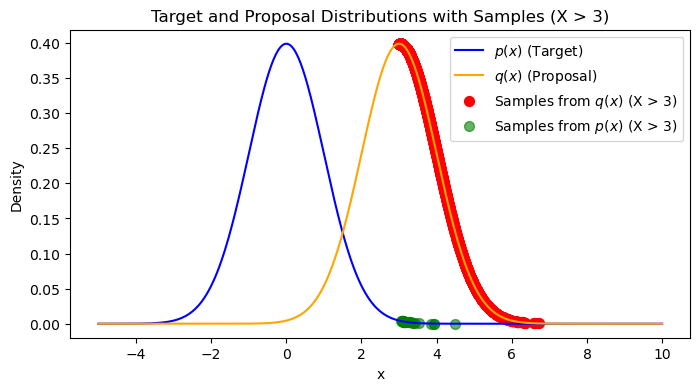

In [11]:
## Step 5: Plotting target, proposal and samples obtained

# Plot the distributions and samples
x = np.linspace(-5, 10, 500)
p_x_vals = norm.pdf(x, mu_p, sigma_p)
q_x_vals = norm.pdf(x, mu_q, sigma_q)

# Plot target and proposal distributions
plt.figure(figsize=(8, 4))
plt.plot(x, p_x_vals, label=r"$p(x)$ (Target)", color="blue")
plt.plot(x, q_x_vals, label=r"$q(x)$ (Proposal)", color="orange")

# Plot samples from q(x) where X > 3
samples_q_greater_than_3 = samples_q[samples_q > 3]
val_samples_q_greater_than_3 = norm.pdf(samples_q_greater_than_3, mu_q, sigma_q)
plt.scatter(samples_q_greater_than_3, val_samples_q_greater_than_3, 
            color="red", marker="o", s=50, label="Samples from $q(x)$ (X > 3)")

# Plot samples from p(x) where X > 3
samples_p_greater_than_3 = samples_p[samples_p > 3]
val_samples_p_greater_than_3 = norm.pdf(samples_p_greater_than_3, mu_p, sigma_p)
plt.scatter(samples_p_greater_than_3, val_samples_p_greater_than_3, 
            color="green", marker="o", s=50, label="Samples from $p(x)$ (X > 3)", alpha=0.6)

# Labels and legend
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Target and Proposal Distributions with Samples (X > 3)")
plt.legend()
plt.show()